In [25]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import h5py
import json
from utils import make_nice_plots
from tqdm import tqdm
make_nice_plots()

In [26]:
def get_colors(origin_dict):
    colors = np.zeros(len(origin_dict), dtype=str)
    for i, value in enumerate(origin_dict.values()):
        if value:
            colors[i] = 'blue'
        else:
            colors[i] = 'red'
    return colors

In [27]:
origin_dict = {}

json_path = '/net/vdesk/data2/pouw/MRP/mockdata_analysis/darksirenpop/jsons/dl_1.0percent_dz_0percent_nagn_10000_dsky_100_200.json'
with open(json_path) as f:
    posterior_samples_dictionary = json.load(f)

for key, filename in posterior_samples_dictionary.items():
    with h5py.File(filename, 'r') as f:
        origin_dict[key] = f['mock']['truths']['from_agn'][()].astype(bool)


In [28]:
fname = 'dl_1.0percent_dz_0percent_nagn_10000_dsky_100_200'

cw_pagn = np.load(f'cweighted_pagn_sky_{fname}.npy')
palt = np.load(f'palt_sky_{fname}.npy')
cw_palt = np.load(f'cweighted_palt_sky_{fname}.npy')
agn_events = np.array([val for val in origin_dict.values()])
alt_events = ~agn_events
colors = get_colors(origin_dict)

selection = np.logical_or((cw_pagn > cw_palt) & agn_events, (cw_pagn < cw_palt) & alt_events) & (cw_pagn > 1e-24)
print(np.sum(selection))

selection = cw_pagn > 1e-24
# cw_pagn = cw_pagn[selection]
# palt = palt[selection]
# cw_palt = cw_palt[selection]
# agn_events = agn_events[selection]
# alt_events = ~agn_events
# colors = colors[selection]

5050


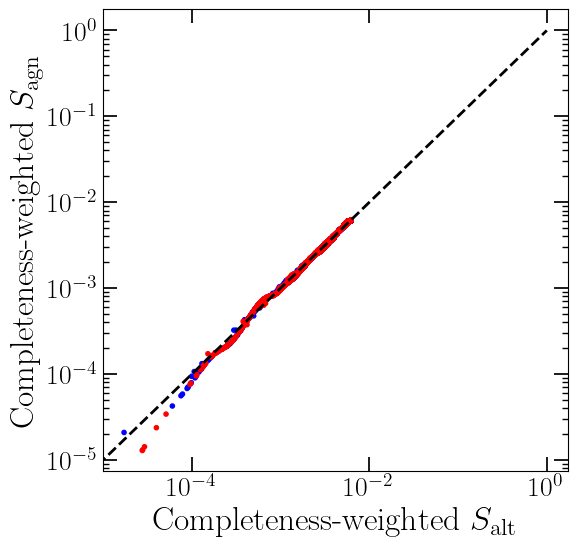

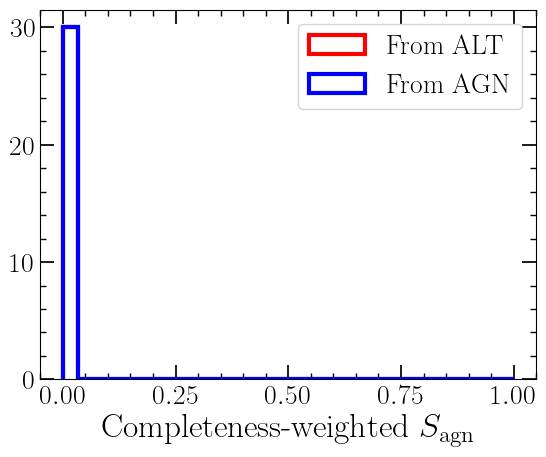

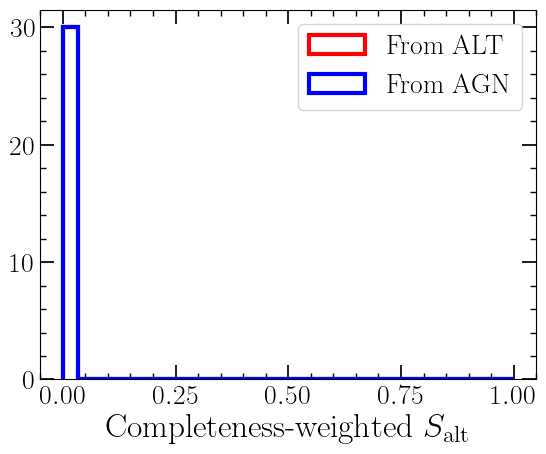

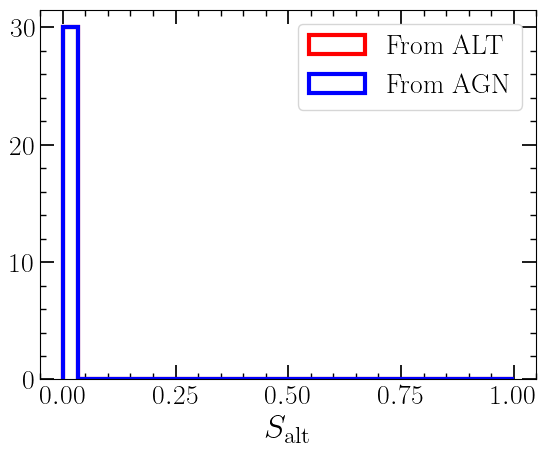

In [29]:
xmin = 0  # min(np.min(pagn), np.min(palt))
xmax = 1 # max(np.max(cw_pagn), np.max(cw_palt))
xx = np.linspace(xmin, xmax, 100)

plt.figure(figsize=(6,6))
plt.scatter(cw_palt, cw_pagn, marker='.', color=colors)
plt.plot(xx, xx, color='black', linestyle='dashed', linewidth=2)
# plt.semilogy()
plt.loglog()
plt.xlabel(r'Completeness-weighted $S_{\rm alt}$')
plt.ylabel(r'Completeness-weighted $S_{\rm agn}$')
# plt.savefig('evidence_v8.pdf', bbox_inches='tight')
plt.show()

edges = np.linspace(xmin, xmax, 31)
plt.figure()
plt.hist(cw_pagn[alt_events], bins=edges, density=True, histtype='step', color='red', linewidth=3, label='From ALT')
plt.hist(cw_pagn[agn_events], bins=edges, density=True, histtype='step', color='blue', linewidth=3, label='From AGN')
# plt.semilogx()
plt.legend()
plt.xlabel(r'Completeness-weighted $S_{\rm agn}$')
plt.show()

xmin = 0
xmax = 1
edges = np.linspace(xmin, xmax, 31)

plt.figure()
plt.hist(cw_palt[alt_events], bins=edges, density=True, histtype='step', color='red', linewidth=3, label='From ALT')
plt.hist(cw_palt[agn_events], bins=edges, density=True, histtype='step', color='blue', linewidth=3, label='From AGN')
# plt.semilogx()
plt.legend()
plt.xlabel(r'Completeness-weighted $S_{\rm alt}$')
plt.show()

plt.figure()
plt.hist(palt[alt_events], bins=edges, density=True, histtype='step', color='red', linewidth=3, label='From ALT')
plt.hist(palt[agn_events], bins=edges, density=True, histtype='step', color='blue', linewidth=3, label='From AGN')
# plt.semilogx()
plt.legend()
plt.xlabel(r'$S_{\rm alt}$')
plt.show()


Chunking...


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


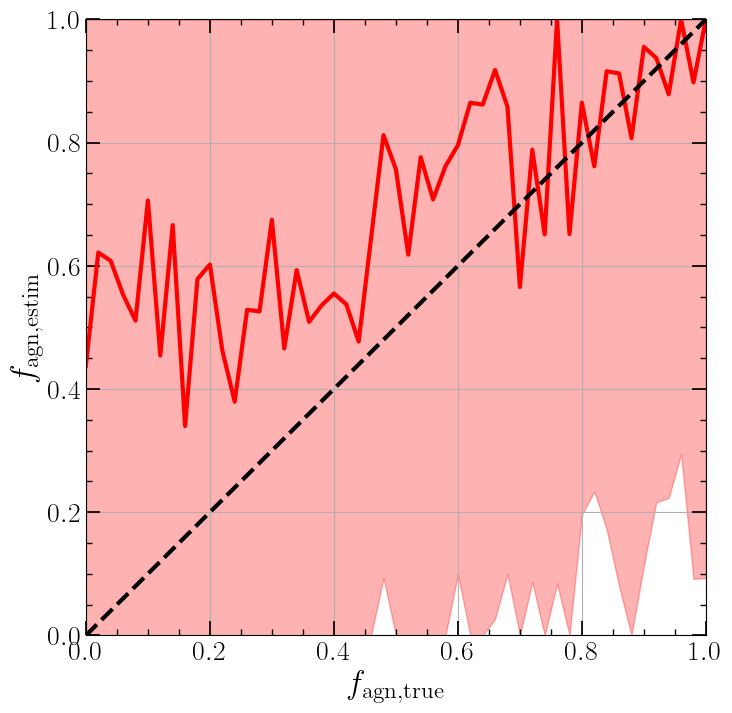

In [36]:
use_N_gws = 1000
max_N_fagns = 51
N_true_fagns = min(use_N_gws+1, max_N_fagns)    # Cannot create more f_agn values than use_N_gws+1 and don't want to generate more than max_N_fagns
calc_logllh_at_N_points = 1000                  # Only change if you want higher resolution, but why would you?
log_llh_x_ax = np.linspace(0.0001, 0.9999, calc_logllh_at_N_points)
n_trials = 100
gw_chunk_size = 100  # Optimized for my own system - vectorize operations for this many GWs 
llh_chunk_size = 10  # Optimized for my own system - vectorize operations for this many values of f_agn

if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):
    print('Chunking...')

estimation_arr = np.zeros((n_trials, N_true_fagns))
for trial_idx in tqdm(range(n_trials)):
    ## These two lines are for making the underlying truth equal to the actual realization of that truth
    # use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)
    # true_fagns = use_N_agn_events / use_N_gws
    
    ## Otherwise, use these two
    true_fagns = np.linspace(0, 1, N_true_fagns)  # Underlying truth
    use_N_agn_events = np.random.binomial(n=use_N_gws, p=true_fagns)  # Make random realization of a universe with a true fagn

    use_N_alt_events = use_N_gws - use_N_agn_events
    realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth

    agn_idx = np.random.choice(np.where(agn_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
    alt_idx = np.random.choice(np.where(alt_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
    idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)

    fagn_times_fobsc = log_llh_x_ax[:, np.newaxis, np.newaxis]
    total_cw_prob_agn = cw_pagn[idx].T[np.newaxis,...]
    total_cw_prob_alt = cw_palt[idx].T[np.newaxis,...]
    total_prob_alt = palt[idx].T[np.newaxis,...]

    if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):  # Chunking to avoid too large arrays in memory

        log_llh_numerator = np.zeros((calc_logllh_at_N_points, N_true_fagns))
        for i in range(int(use_N_gws / gw_chunk_size)):
            gw_start, gw_stop = int(i * gw_chunk_size), int((i + 1) * gw_chunk_size)
            cw_agn_prob_chunk = total_cw_prob_agn[:, gw_start:gw_stop, :]
            cw_alt_prob_chunk = total_cw_prob_alt[:, gw_start:gw_stop, :]
            alt_prob_chunk = total_prob_alt[:, gw_start:gw_stop, :]

            for j in range(int(calc_logllh_at_N_points / llh_chunk_size)):
                llh_start, llh_stop = int(j * llh_chunk_size), int((j + 1) * llh_chunk_size)
                fagn_chunk = fagn_times_fobsc[llh_start:llh_stop, ...]
                fagn_times_cw_p_agn = fagn_chunk * cw_agn_prob_chunk
                fagn_times_cw_p_alt = fagn_chunk * cw_alt_prob_chunk
                alt_prob_chunk_rightshape = np.ones_like(fagn_chunk) * alt_prob_chunk  # TODO: This shape correction doesn't seem to matter

                log_prob = np.log(fagn_times_cw_p_agn + alt_prob_chunk_rightshape - fagn_times_cw_p_alt)
                log_llh_numerator[llh_start:llh_stop, :] += np.sum(log_prob, axis=1)
    else:
        log_llh_numerator_per_event = np.log(fagn_times_fobsc * total_cw_prob_agn + total_prob_alt - fagn_times_fobsc * total_cw_prob_alt)
        log_llh_numerator = np.sum(log_llh_numerator_per_event, axis=1 )  

    log_llh_denominator = 0  # TODO: GW selection effects
    log_llh = log_llh_numerator - log_llh_denominator
    # max_log_llh = np.max(log_llh, axis=0)
    estimation_arr[trial_idx, :] = log_llh_x_ax[np.argmax(log_llh, axis=0)]  # TODO: change to interpolation

fagn_medians = np.median(estimation_arr, axis=0)
q016 = np.quantile(estimation_arr, 0.16, axis=0)
q084 = np.quantile(estimation_arr, 0.84, axis=0)

plt.figure(figsize=(8,8))
plt.plot(true_fagns, fagn_medians, color='red', linewidth=3)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
plt.fill_between(true_fagns, q016, q084, color='red', alpha=0.3)

# CI = np.linspace(0, 1, 1001)
# for ci, alpha in zip([0.68, 0.95, 0.997], [0.1, 0.15, 0.2]):
#     edge_of_bound = (1. - ci) / 2.
#     lower = binom.ppf(1 - edge_of_bound, use_N_gws, CI) / use_N_gws
#     upper = binom.ppf(edge_of_bound, use_N_gws, CI) / use_N_gws
#     lower[0] = 0
#     upper[0] = 0
#     plt.fill_between(CI, lower, upper, alpha=alpha, color='k')

plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
# plt.legend()
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


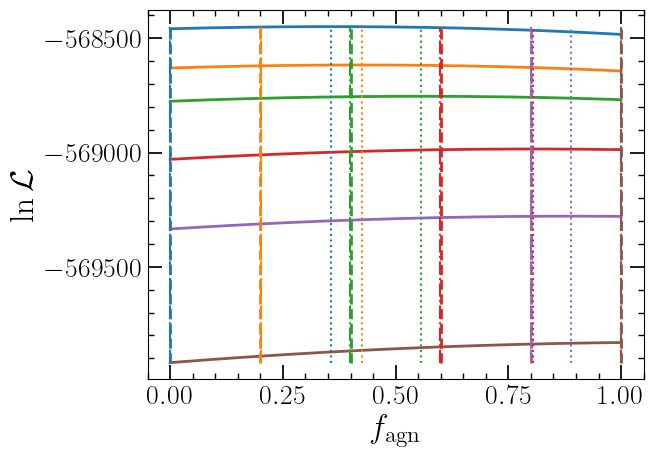

In [31]:
plt.figure()
ymin = np.inf
ymax = -np.inf
ax_factor = 1.1
color_list = []
every = 10
for i, llh in enumerate(log_llh.T[::every]):

    low, high = np.min(llh), np.max(llh)
    if ymin > low:
        ymin = low
    if ymax < high:
        ymax = high

    p = plt.plot(log_llh_x_ax, llh, linewidth=2, linestyle='solid', label='Total log-likelihood')
    c = color_list.append( p[0].get_color() )

plt.vlines(true_fagns[::every], ymin, ymax, color=color_list, linestyle='dashed', linewidth=2, label=r'True $f_{\rm agn}$')
plt.vlines(realized_fagns[::every], ymin, ymax, color=color_list, linestyle='dashdot', label=r'Realized $f_{\rm agn}$')
plt.vlines(fagn_medians[::every], ymin, ymax, color=color_list, linestyle='dotted', label=r'Estimated $f_{\rm agn}$')
# plt.legend()
# plt.ylim(ymin / ax_factor, ax_factor * ymax)
plt.xlabel(r'$f_{\rm agn}$')
plt.ylabel(r'$\ln \mathcal{L}$')
plt.show()


In [32]:
# from utils import uniform_shell_sampler, fast_z_at_value
# from default_arguments import DEFAULT_COSMOLOGY
# import astropy.units as u

# rcom_samps, _, _ = uniform_shell_sampler(0, 100000, 1000000) * u.Mpc
# zsamps = fast_z_at_value(DEFAULT_COSMOLOGY.comoving_distance, rcom_samps)
# rlum_samps = (1 + zsamps) * rcom_samps.value

# plt.figure()
# plt.hist(DEFAULT_COSMOLOGY.luminosity_distance(zsamps), density=True, bins=30, histtype='step', zorder=3, color='black')
# plt.hist(rlum_samps, density=True, bins=30)
# plt.show()


In [33]:
# dtrue=10000. #true distance
# sigma=0.2 #variance multiplier
# dobs=dtrue*(1.+sigma*np.random.normal()) #Observed distance

# nsamps=200000 #sample size
# dtpostsamps=dobs/(1+sigma*np.random.normal(size=nsamps)) #samples from incorrect distribution

# resampsize=100000 #Number of (re)samples from target distribution
# wts=dtpostsamps/np.sum(dtpostsamps) #Importance weights
# resamples=np.random.choice(dtpostsamps,resampsize,p=wts) #resamples

# z_samples = fast_z_at_value(DEFAULT_COSMOLOGY.luminosity_distance, resamples * u.Mpc)

# H_z = DEFAULT_COSMOLOGY.H(z_samples).value  # H(z) in km/s/Mpc
# chi_z = DEFAULT_COSMOLOGY.comoving_distance(z_samples).value  # in Mpc
# dDL_dz = chi_z + (1 + z_samples) * (3e5 / H_z)  # c = 3e5 km/s
# resamped_z = np.random.choice(z_samples, int(resampsize/2), p=1/dDL_dz / (np.sum(1/dDL_dz)))

# plt.figure()
# plt.hist(resamples, density=True, bins=50)
# plt.show()

# edges = np.linspace(0, 5, 101)
# plt.figure()
# plt.hist(z_samples, density=True, bins=edges)
# plt.hist(resamped_z, density=True, bins=edges)
# plt.show()


In [34]:
# print(DEFAULT_COSMOLOGY.comoving_distance(0.1))

# from scipy.integrate import quad
# xmax = 100000
# pdf = lambda x: x**2 / (xmax**3 / 3)

# plt.figure()
# plt.hist(rcom_samps, density=True, bins=30)
# plt.plot(np.linspace(0, 100000, 100), pdf(np.linspace(0, 100000, 100)))
# plt.show()
